Loaded 15 images.
Pixel range (min, max): -421.1719516057899 570461.2871607031


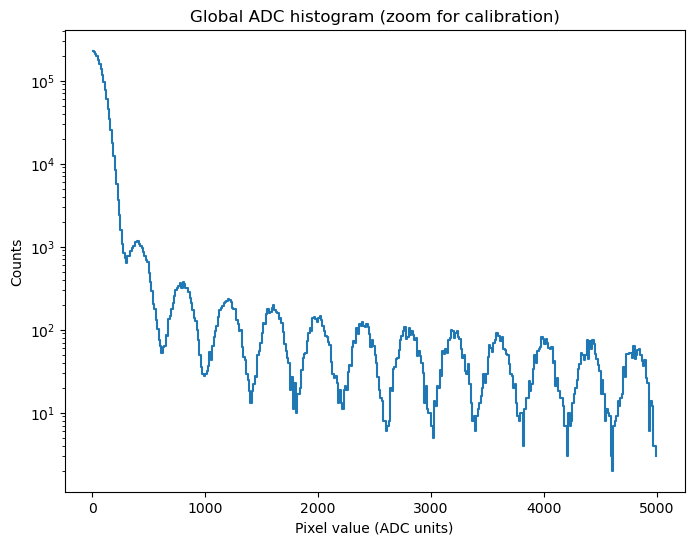

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from scipy import ndimage
from scipy.stats import poisson

# =========================================================
# 0. LOAD ALL CCD FILES (15 images)
# =========================================================

file_names = [f"sensei_data_{i}.csv" for i in range(1, 16)]
imgs = [np.loadtxt(fn, delimiter=",") for fn in file_names]
N_files = len(imgs)
print(f"Loaded {N_files} images.")

# =========================================================
# 1. GLOBAL PIXEL HISTOGRAM (ADC units) — for calibration
# =========================================================

all_pixels = np.concatenate([im.ravel() for im in imgs])
print("Pixel range (min, max):", all_pixels.min(), all_pixels.max())

# histogram range where the peaks are visible (adjust if needed)
hist_range = (0, 5000)
bins_calib = 400

counts, bin_edges = np.histogram(all_pixels, bins=bins_calib, range=hist_range)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

plt.figure(figsize=(8,6))
plt.plot(bin_centers, counts, drawstyle="steps-mid")
plt.yscale("log")
plt.xlabel("Pixel value (ADC units)")
plt.ylabel("Counts")
plt.title("Global ADC histogram (zoom for calibration)")
plt.show()


=== Gaussian Fit for 0 e- Peak ===
mu0   = -0.4015600314618953
sigma = 80.38815936006424


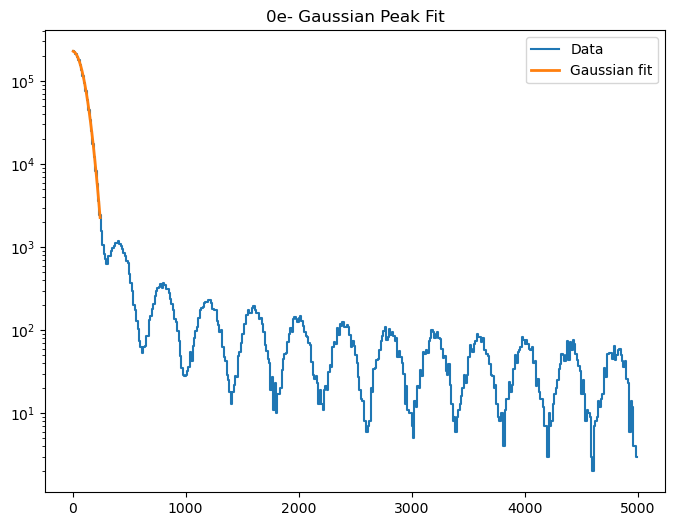

In [2]:
# =========================================================
# 2. FIT THE 0e- PEAK WITH A GAUSSIAN
# =========================================================

def gaussian(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2*sigma**2))

max_idx = np.argmax(counts)  # where 0e- peak is located
mu0_guess = bin_centers[max_idx]

half_window = 20
start = max(0, max_idx - half_window)
end = min(len(bin_centers), max_idx + half_window)

x0 = bin_centers[start:end]
y0 = counts[start:end]

p0 = [y0.max(), mu0_guess, 50.0]  # initial guess: amplitude, mean, sigma
params0, cov0 = curve_fit(gaussian, x0, y0, p0)
A0, mu0, sigma0 = params0

print("\n=== Gaussian Fit for 0 e- Peak ===")
print("mu0   =", mu0)
print("sigma =", sigma0)

plt.figure(figsize=(8,6))
plt.plot(bin_centers, counts, drawstyle="steps-mid", label="Data")
plt.plot(x0, gaussian(x0, *params0), label="Gaussian fit", lw=2)
plt.yscale("log")
plt.legend()
plt.title("0e- Gaussian Peak Fit")
plt.show()


Peak positions (first 10):
[ 406.25  806.25 1206.25 1606.25 2018.75 2393.75 2768.75 3181.25 3581.25
 3981.25]

=== ADC → electron calibration ===
mu0_line = 414.58333333333275
Delta    = 395.38690476190465 ADC units per 1 e-


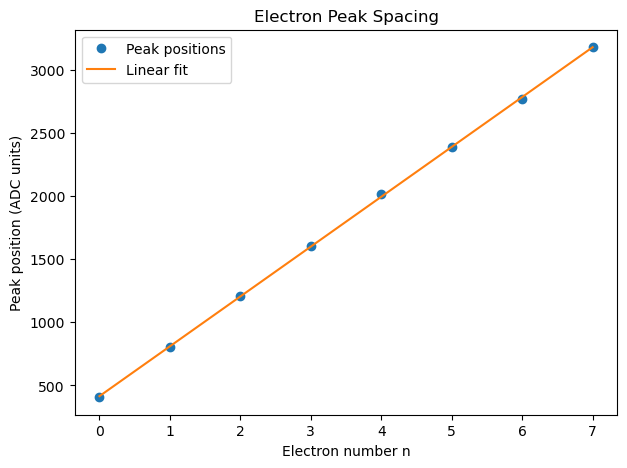

In [3]:
# =========================================================
# 3. FIND MULTIPLE PEAKS (0e-, 1e-, 2e-...) AND FIT LINEAR SPACING
# =========================================================

peaks_idx, props = find_peaks(counts, prominence=50)
peak_positions = np.sort(bin_centers[peaks_idx])

print("\nPeak positions (first 10):")
print(peak_positions[:10])

N_use = min(8, len(peak_positions))
pk = peak_positions[:N_use]
n_e = np.arange(N_use)

coef = np.polyfit(n_e, pk, 1)  # linear fit: pk ≈ mu0_line + Delta*n
Delta = coef[0]
mu0_line = coef[1]

print("\n=== ADC → electron calibration ===")
print("mu0_line =", mu0_line)
print("Delta    =", Delta, "ADC units per 1 e-")

plt.figure(figsize=(7,5))
plt.plot(n_e, pk, "o", label="Peak positions")
plt.plot(n_e, mu0_line + Delta*n_e, "-", label="Linear fit")
plt.xlabel("Electron number n")
plt.ylabel("Peak position (ADC units)")
plt.legend()
plt.title("Electron Peak Spacing")
plt.show()

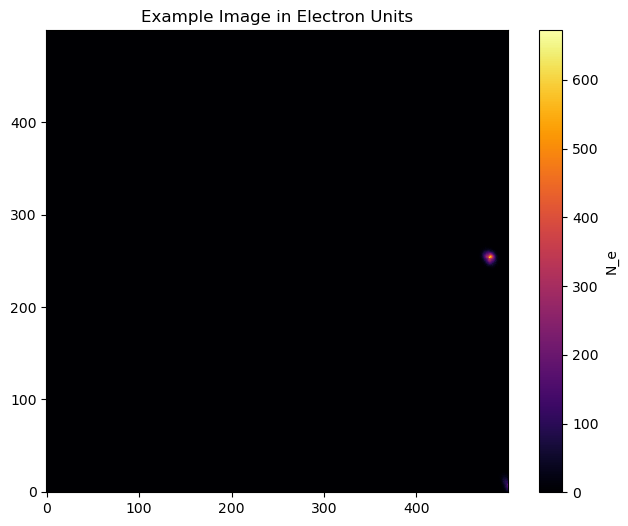

In [4]:
# =========================================================
# 4. CONVERT EACH IMAGE TO ELECTRONS
# =========================================================

def adc_to_electrons(img_adc, mu0, Delta):
    """
    Converts ADC units → electrons by rounding to nearest integer.
    """
    ne = (img_adc - mu0) / Delta
    ne_round = np.rint(ne).astype(int)
    ne_round[ne_round < 0] = 0  # no negative electrons
    return ne_round

mu0_use = mu0_line

imgs_ne = [adc_to_electrons(im, mu0_use, Delta) for im in imgs]

plt.figure(figsize=(8,6))
plt.imshow(imgs_ne[0], cmap="inferno", origin="lower")
plt.colorbar(label="N_e")
plt.title("Example Image in Electron Units")
plt.show()

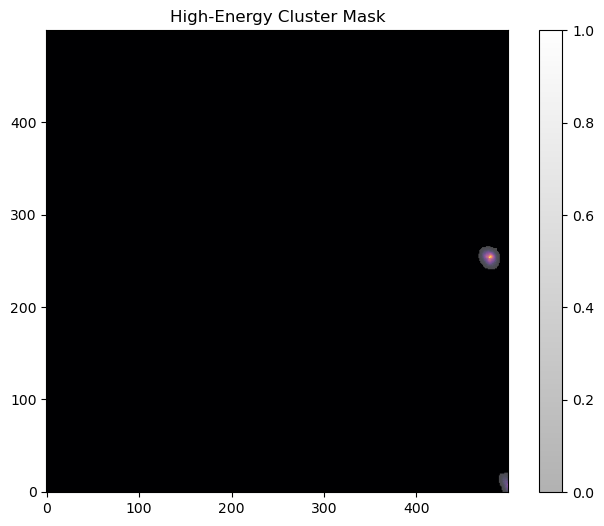

In [7]:
# =========================================================
# 5. DETECT AND MASK HIGH-ENERGY CLUSTERS
# =========================================================

threshold_high = 20  # electrons
masks = []

for ne_img in imgs_ne:
    high = ne_img > threshold_high
    labeled, num_clusters = ndimage.label(high)
    dilated = ndimage.binary_dilation(labeled > 0,
                                     structure=np.ones((3,3)),
                                     iterations=2)
    masks.append(dilated)

plt.figure(figsize=(8,6))
plt.imshow(imgs_ne[0], cmap="inferno", origin="lower")
plt.imshow(masks[0], cmap="gray", origin="lower", alpha=0.3)
plt.colorbar()
plt.title("High-Energy Cluster Mask")
plt.show()

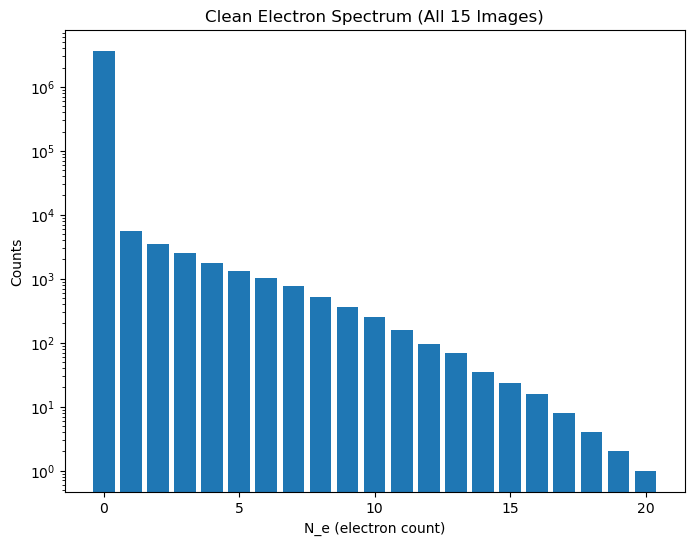

In [8]:
# =========================================================
# 6. BUILD CLEAN ELECTRON SPECTRUM (COMBINED)
# =========================================================

all_ne_clean = np.concatenate([
    ne_img[~mask] for ne_img, mask in zip(imgs_ne, masks)
])

max_ne_plot = 20
vals = all_ne_clean[(all_ne_clean >= 0) & (all_ne_clean <= max_ne_plot)]

bins_ne = np.arange(-0.5, max_ne_plot + 1.5, 1)
hist_ne, edges_ne = np.histogram(vals, bins=bins_ne)
ne_centers = 0.5*(edges_ne[:-1] + edges_ne[1:])

plt.figure(figsize=(8,6))
plt.bar(ne_centers, hist_ne, width=0.8)
plt.yscale("log")
plt.xlabel("N_e (electron count)")
plt.ylabel("Counts")
plt.title("Clean Electron Spectrum (All 15 Images)")
plt.show()

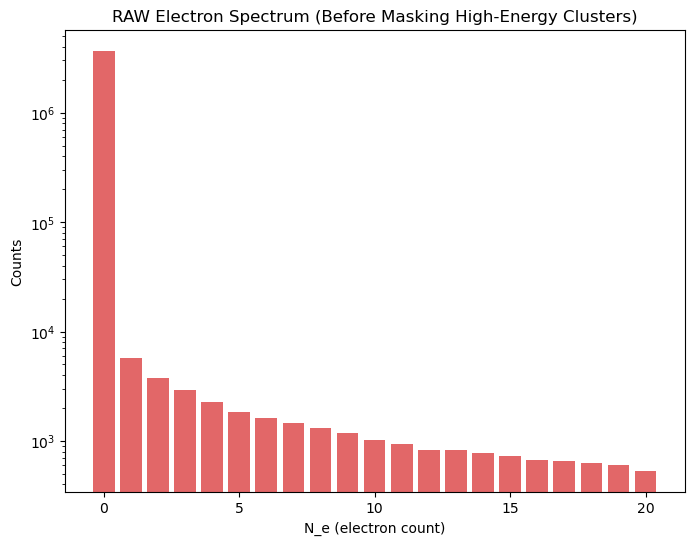

In [12]:
# =========================================================
# BUILD ELECTRON SPECTRUM *BEFORE* MASKING HIGH-ENERGY EVENTS
# =========================================================

# Concatenate ALL pixels from all images in electron units
all_ne_raw = np.concatenate([ne_img.ravel() for ne_img in imgs_ne])

max_ne_plot = 20
vals_raw = all_ne_raw[(all_ne_raw >= 0) & (all_ne_raw <= max_ne_plot)]

bins_ne = np.arange(-0.5, max_ne_plot + 1.5, 1)
hist_ne_raw, edges_ne_raw = np.histogram(vals_raw, bins=bins_ne)

ne_centers = 0.5 * (edges_ne_raw[:-1] + edges_ne_raw[1:])

plt.figure(figsize=(8,6))
plt.bar(ne_centers, hist_ne_raw, width=0.8, color="tab:red", alpha=0.7)
plt.yscale("log")
plt.xlabel("N_e (electron count)")
plt.ylabel("Counts")
plt.title("RAW Electron Spectrum (Before Masking High-Energy Clusters)")
plt.show()


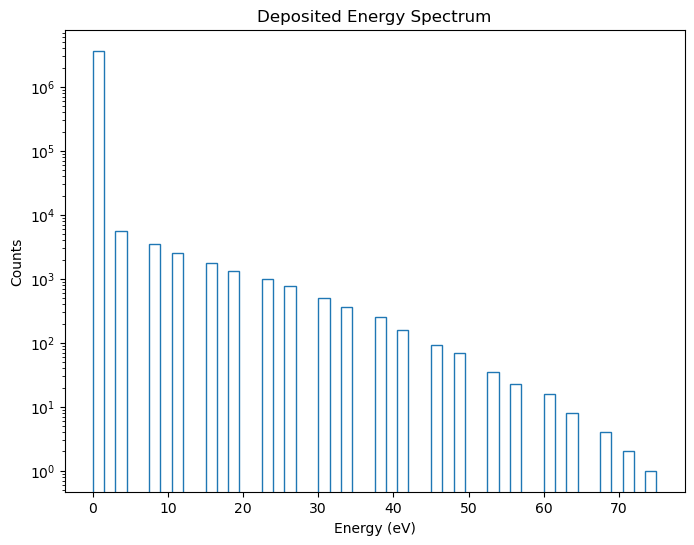

In [10]:
# =========================================================
# 7. CONVERT N_e → ENERGY (eV)
# =========================================================

E_per_e = 3.75  # eV per electron in silicon
energies = vals * E_per_e

plt.figure(figsize=(8,6))
plt.hist(energies, bins=50, histtype="step")
plt.yscale("log")
plt.xlabel("Energy (eV)")
plt.ylabel("Counts")
plt.title("Deposited Energy Spectrum")
plt.show()

In [15]:
# =========================================================
# 6. BUILD CLEAN ELECTRON SPECTRUM (AFTER MASKING)
# =========================================================

all_ne_clean = np.concatenate([
    ne_img[~mask] for ne_img, mask in zip(imgs_ne, masks)
])

max_ne_plot = 20
vals_clean = all_ne_clean[(all_ne_clean >= 0) & (all_ne_clean <= max_ne_plot)]

bins_ne = np.arange(-0.5, max_ne_plot + 1.5, 1)
hist_ne_clean, edges_ne_clean = np.histogram(vals_clean, bins=bins_ne)

ne_centers = 0.5*(edges_ne_clean[:-1] + edges_ne_clean[1:])

A = 3694358.4583622413
lambda = 0.001512220432975448


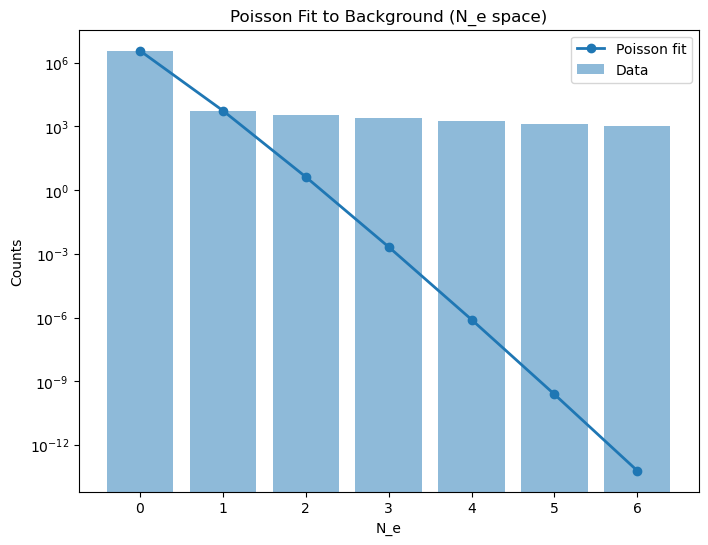

In [16]:
# =========================================================
# 8. OPTIONAL: POISSON FIT TO BACKGROUND
# =========================================================

from scipy.stats import poisson
from scipy.optimize import curve_fit

def poisson_model(n, A, lam):
    """Poisson background model: counts as a function of N_e."""
    return A * poisson.pmf(n, lam)

# Use electron counts, not energy
n_vals = ne_centers.astype(int)       # 0,1,2,...
hist_vals = hist_ne_clean.copy()      # counts per N_e bin

# Restrict to first few bins (0–6 e-) where background dominates
max_fit = 6
n_fit = n_vals[:max_fit+1]
hist_fit = hist_vals[:max_fit+1]

# Remove empty bins to avoid numerical issues
mask = hist_fit > 0
n_fit = n_fit[mask]
hist_fit = hist_fit[mask]

# Initial guesses
A0 = hist_fit.sum()   # total counts in fitted range
lam0 = 0.5            # mean electrons per pixel (rough guess)

popt, pcov = curve_fit(poisson_model, n_fit, hist_fit, p0=[A0, lam0])
A_fit, lambda_fit = popt

print("A =", A_fit)
print("lambda =", lambda_fit)

# Plot data + fit
plt.figure(figsize=(8,6))
plt.bar(n_fit, hist_fit, width=0.8, alpha=0.5, label="Data")
plt.plot(n_fit,
         poisson_model(n_fit, A_fit, lambda_fit),
         "o-", lw=2, label="Poisson fit")
plt.yscale("log")
plt.xlabel("N_e")
plt.ylabel("Counts")
plt.title("Poisson Fit to Background (N_e space)")
plt.legend()
plt.show()


In [17]:
print("mu0 =", mu0_use)
print("Delta =", Delta)
print("sigma0 =", sigma0)
print("ne_centers:", ne_centers)
print("hist_ne_clean:", hist_ne_clean)

mu0 = 414.58333333333275
Delta = 395.38690476190465
sigma0 = 80.38815936006424
ne_centers: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20.]
hist_ne_clean: [3688776    5573    3469    2544    1787    1341    1009     762     509
     357     254     157      94      70      35      23      16       8
       4       2       1]
